In [7]:
import pandas as pd
import numpy as np
import yfinance as yf

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest

In [10]:
import scipy.interpolate as interp
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [15]:
sp_df = yf.download('^GSPC', 
                      start='2011-09-13', 
                      end='2019-12-13', 
                      progress=False,interval='1d')
ohlc = sp_df.iloc[:,:4]
ohlc

,Open,High,Low,Close
Date,,,,
2011-09-12,1153.500000,1162.520020,1136.069946,1162.270020
2011-09-13,1162.589966,1176.410034,1157.439941,1172.869995
2011-09-14,1173.319946,1202.380005,1162.729980,1188.680054
2011-09-15,1189.439941,1209.109985,1189.439941,1209.109985
2011-09-16,1209.209961,1220.060059,1204.459961,1216.010010
...,...,...,...,...
2019-12-06,3134.620117,3150.600098,3134.620117,3145.909912
2019-12-09,3141.860107,3148.870117,3135.459961,3135.959961
2019-12-10,3135.360107,3142.120117,3126.090088,3132.520020


In [51]:
yr1 = ohlc.loc['2018-12-12':]
yr2 = ohlc.loc['2017-12-12':]
yr4 = ohlc.loc['2015-12-12':]

# Strategies

In [5]:
def SMA(values,n):
    return pd.Series(values).rolling(n).mean()

In [6]:
class SmaCross(Strategy):
    
    n1 = 50
    n2 = 200
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [18]:
def EMA(val,n):
    res = pd.Series(val).copy()
    return res.ewm(span=n,adjust=False).mean()

In [19]:
class EmaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.ema2, self.ema1):
            self.sell()

In [22]:
def DEMA(val,n):
    exp1 = EMA(val,n)
    exp2 = EMA(exp1,n)
    return 2*exp1 - exp2

In [23]:
class DemaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.dema1 = self.I(DEMA, self.data.Close, self.n1)
        self.dema2 = self.I(DEMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.dema1, self.dema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.dema2, self.dema1):
            self.sell()

# Strategies for Time Horizons

In [53]:
def time_horiz(hist,ma):
    
    if ma == 'SMA':
        bt = Backtest(hist,SmaCross,cash=10000)
    elif ma == 'EMA':
        bt = Backtest(hist,EmaCross,cash=10000)
    elif ma == 'DEMA':
        bt = Backtest(hist,DemaCross,cash=10000)
    
    data, heat = bt.optimize('Sharpe Ratio',n1=range(1,101,3),n2=range(1,101,3),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

    heat.sort_values()
    hmap = heat.groupby(['n1','n2']).mean().unstack()
    hmap

    heat_pic = sns.heatmap(hmap, cmap='Spectral')
    
    tr = hmap.stack()

    n1 = [i[0] for i in tr.index]
    n2 = [i[1] for i in tr.index]

    val = []
    for (i,j) in zip(n1,n2):
        if i<j:
            val.append(tr.loc[i,j])

    px, py = np.meshgrid(np.linspace(np.min(n1),np.max(n1),100),np.linspace(np.min(n2),np.max(n2),100))
    pz = interp.griddata((n1,n2),val,(px,py),method='cubic')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(px,py,pz,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
    return data

# 1 Year SMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Searching best of 561 configurations.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


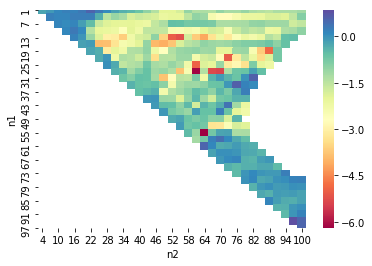

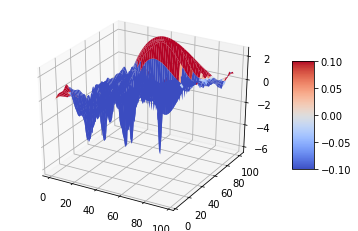

Start                       2018-12-12 00:00:00
End                         2019-12-12 00:00:00
Duration                      365 days 00:00:00
Exposure [%]                            24.9315
Equity Final [$]                        10519.6
Equity Peak [$]                         10641.9
Return [%]                              5.19607
Buy & Hold Return [%]                   19.5204
Max. Drawdown [%]                      -3.48187
Avg. Drawdown [%]                     -0.752078
Max. Drawdown Duration         22 days 00:00:00
Avg. Drawdown Duration          7 days 00:00:00
# Trades                                      4
Win Rate [%]                                 75
Best Trade [%]                          4.15873
Worst Trade [%]                       -0.106304
Avg. Trade [%]                          1.56032
Max. Trade Duration            53 days 00:00:00
Avg. Trade Duration            23 days 00:00:00
Expectancy [%]                          1.61347
SQN                                     

In [54]:
time_horiz(yr1,'SMA')

# 1 Year EMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Searching best of 561 configurations.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


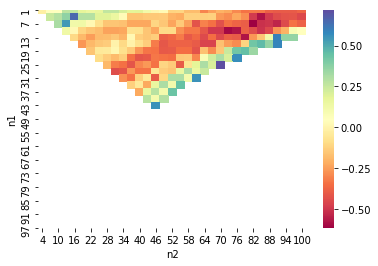

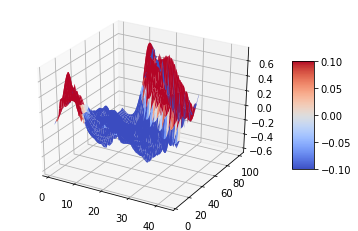

Start                       2018-12-12 00:00:00
End                         2019-12-12 00:00:00
Duration                      365 days 00:00:00
Exposure [%]                            58.9041
Equity Final [$]                        11809.9
Equity Peak [$]                         11809.9
Return [%]                              18.0989
Buy & Hold Return [%]                   19.5204
Max. Drawdown [%]                      -6.83611
Avg. Drawdown [%]                      -1.20881
Max. Drawdown Duration         94 days 00:00:00
Avg. Drawdown Duration         12 days 00:00:00
# Trades                                      2
Win Rate [%]                                100
Best Trade [%]                          8.31626
Worst Trade [%]                       0.0469624
Avg. Trade [%]                          4.18161
Max. Trade Duration           210 days 00:00:00
Avg. Trade Duration           108 days 00:00:00
Expectancy [%]                              NaN
SQN                                     

In [55]:
time_horiz(yr1,'EMA')

# 1 Year DEMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Searching best of 561 configurations.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


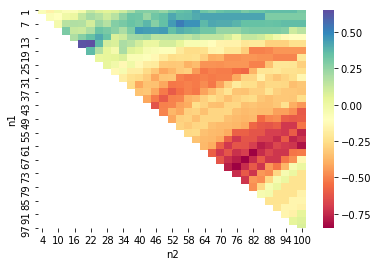

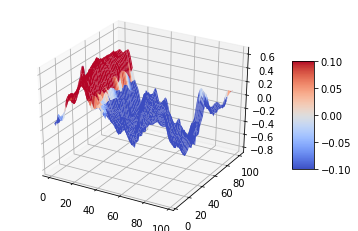

Start                        2018-12-12 00:00:00
End                          2019-12-12 00:00:00
Duration                       365 days 00:00:00
Exposure [%]                              90.137
Equity Final [$]                         11639.4
Equity Peak [$]                          12080.7
Return [%]                               16.3938
Buy & Hold Return [%]                    19.5204
Max. Drawdown [%]                       -5.88911
Avg. Drawdown [%]                       -1.94792
Max. Drawdown Duration          66 days 00:00:00
Avg. Drawdown Duration          18 days 00:00:00
# Trades                                       9
Win Rate [%]                             77.7778
Best Trade [%]                           8.13436
Worst Trade [%]                         -2.98032
Avg. Trade [%]                           1.98464
Max. Trade Duration             56 days 00:00:00
Avg. Trade Duration             37 days 00:00:00
Expectancy [%]                           2.77232
SQN                 

In [57]:
time_horiz(yr1,'DEMA')

# 2 Year SMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Searching best of 561 configurations.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


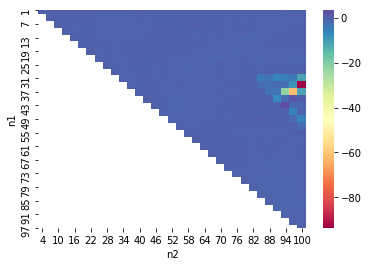

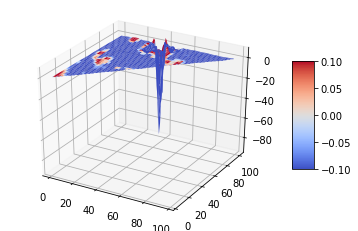

Start                       2017-12-12 00:00:00
End                         2019-12-12 00:00:00
Duration                      730 days 00:00:00
Exposure [%]                            36.3014
Equity Final [$]                        11462.6
Equity Peak [$]                         11699.2
Return [%]                              14.6264
Buy & Hold Return [%]                   18.9354
Max. Drawdown [%]                      -15.1791
Avg. Drawdown [%]                      -3.05322
Max. Drawdown Duration        353 days 00:00:00
Avg. Drawdown Duration         41 days 00:00:00
# Trades                                      2
Win Rate [%]                                100
Best Trade [%]                         0.664352
Worst Trade [%]                        0.426596
Avg. Trade [%]                         0.545474
Max. Trade Duration           148 days 00:00:00
Avg. Trade Duration           133 days 00:00:00
Expectancy [%]                              NaN
SQN                                     

In [58]:
time_horiz(yr2,'SMA')

# 2 Year EMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Searching best of 561 configurations.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


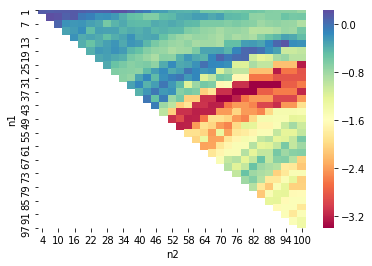

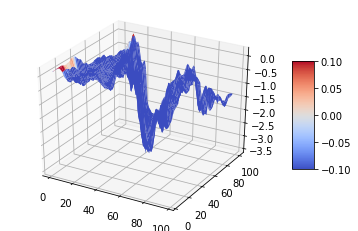

Start                     2017-12-12 00:00:00
End                       2019-12-12 00:00:00
Duration                    730 days 00:00:00
Exposure [%]                          98.7671
Equity Final [$]                        12990
Equity Peak [$]                       13252.3
Return [%]                            29.8998
Buy & Hold Return [%]                 18.9354
Max. Drawdown [%]                    -11.2204
Avg. Drawdown [%]                    -2.26632
Max. Drawdown Duration      316 days 00:00:00
Avg. Drawdown Duration       30 days 00:00:00
# Trades                                   46
Win Rate [%]                          47.8261
Best Trade [%]                        9.05678
Worst Trade [%]                      -2.53567
Avg. Trade [%]                       0.572842
Max. Trade Duration          59 days 00:00:00
Avg. Trade Duration          16 days 00:00:00
Expectancy [%]                        1.80432
SQN                                   1.48495
Sharpe Ratio                      

In [59]:
time_horiz(yr2,'EMA')

# 2 Year DEMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Searching best of 561 configurations.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


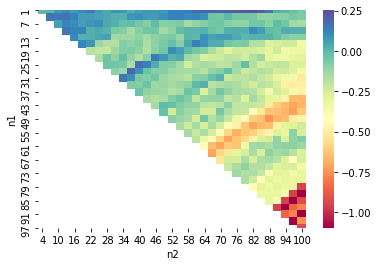

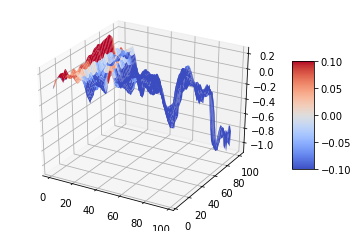

Start                       2017-12-12 00:00:00
End                         2019-12-12 00:00:00
Duration                      730 days 00:00:00
Exposure [%]                            98.2192
Equity Final [$]                        12403.6
Equity Peak [$]                         12518.5
Return [%]                              24.0355
Buy & Hold Return [%]                   18.9354
Max. Drawdown [%]                      -11.2185
Avg. Drawdown [%]                      -2.46512
Max. Drawdown Duration        245 days 00:00:00
Avg. Drawdown Duration         27 days 00:00:00
# Trades                                     28
Win Rate [%]                            42.8571
Best Trade [%]                          11.7883
Worst Trade [%]                        -4.55101
Avg. Trade [%]                         0.754902
Max. Trade Duration           118 days 00:00:00
Avg. Trade Duration            26 days 00:00:00
Expectancy [%]                          1.77042
SQN                                     

In [60]:
time_horiz(yr2,'DEMA')

# 4 Year SMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Searching best of 561 configurations.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


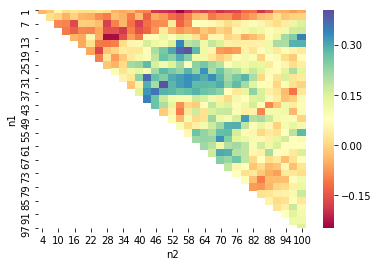

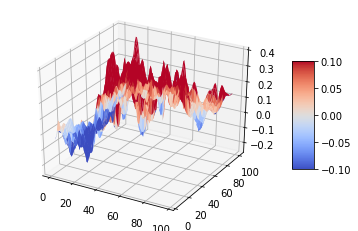

Start                       2015-12-14 00:00:00
End                         2019-12-12 00:00:00
Duration                     1459 days 00:00:00
Exposure [%]                            88.8965
Equity Final [$]                        14331.2
Equity Peak [$]                         15841.1
Return [%]                              43.3119
Buy & Hold Return [%]                   56.7094
Max. Drawdown [%]                       -21.144
Avg. Drawdown [%]                      -1.72843
Max. Drawdown Duration        353 days 00:00:00
Avg. Drawdown Duration         26 days 00:00:00
# Trades                                     16
Win Rate [%]                              56.25
Best Trade [%]                          10.6496
Worst Trade [%]                        -5.71489
Avg. Trade [%]                          1.75064
Max. Trade Duration           161 days 00:00:00
Avg. Trade Duration            82 days 00:00:00
Expectancy [%]                          3.51085
SQN                                     

In [61]:
time_horiz(yr4,'SMA')

# 4 Year EMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Searching best of 561 configurations.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


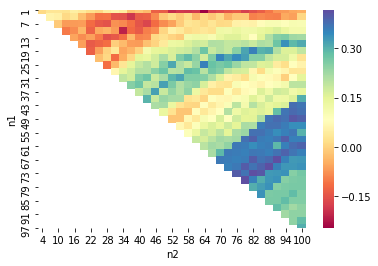

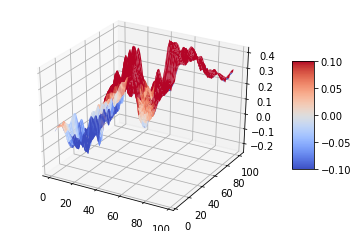

Start                       2015-12-14 00:00:00
End                         2019-12-12 00:00:00
Duration                     1459 days 00:00:00
Exposure [%]                            78.9582
Equity Final [$]                        14437.6
Equity Peak [$]                         14437.6
Return [%]                              44.3763
Buy & Hold Return [%]                   56.7094
Max. Drawdown [%]                      -14.4843
Avg. Drawdown [%]                      -1.71423
Max. Drawdown Duration        368 days 00:00:00
Avg. Drawdown Duration         31 days 00:00:00
# Trades                                      3
Win Rate [%]                            66.6667
Best Trade [%]                          32.8679
Worst Trade [%]                        -6.76668
Avg. Trade [%]                          8.78584
Max. Trade Duration           957 days 00:00:00
Avg. Trade Duration           384 days 00:00:00
Expectancy [%]                           13.297
SQN                                    0

In [62]:
time_horiz(yr4,'EMA')

# 4 Year DEMA

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Searching best of 561 configurations.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.


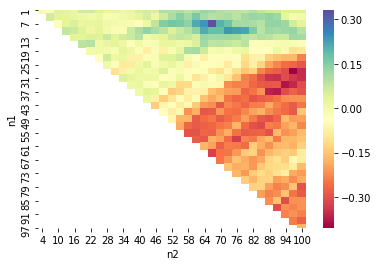

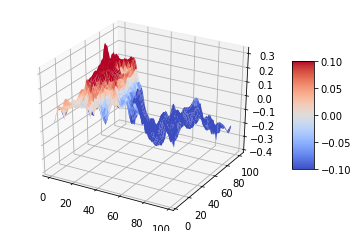

Start                       2015-12-14 00:00:00
End                         2019-12-12 00:00:00
Duration                     1459 days 00:00:00
Exposure [%]                            94.5168
Equity Final [$]                        15374.4
Equity Peak [$]                         15388.8
Return [%]                               53.744
Buy & Hold Return [%]                   56.7094
Max. Drawdown [%]                      -10.8273
Avg. Drawdown [%]                      -2.03942
Max. Drawdown Duration        258 days 00:00:00
Avg. Drawdown Duration         28 days 00:00:00
# Trades                                     39
Win Rate [%]                            46.1538
Best Trade [%]                          11.0269
Worst Trade [%]                        -3.37659
Avg. Trade [%]                         0.992494
Max. Trade Duration           119 days 00:00:00
Avg. Trade Duration            36 days 00:00:00
Expectancy [%]                          2.20441
SQN                                     

In [63]:
time_horiz(yr4,'DEMA')